## Optimal Charging Example

We have an electric storage device with state-of-charge (SOC) $q_t \in \mathbb{R}_+$ at time $t$ and capacity $Q \in \mathbb{R}_+$. We denote the amount of energy charged from time $t$ to time $t+1$ as $u_t \in \mathbb{R}$, i.e., $q_{t+1} = q_t + u_t$. Power is limited by $C \in \mathbb{R}_+$ ($D \in \mathbb{R}_+$), the maximum possible magnitude of charging (discharging) power. The energy price $P(u_t)$ is higher when buying energy from the grid compared to the case of selling energy to the grid. Specifically, 

\begin{equation}
P(u_i) = \begin{cases}
p_t u_t (1+\eta) \quad &\text{if} \quad u_t > 0 \\
p_t u_t (1-\eta) \quad &\text{otherwise},
\end{cases}
\end{equation}

where $p_t \in \mathbb{R}_+$ is the average market price at time $t$ and $0 < \eta < 1$. To optimize the cost of charging the energy storage from empty to full within a time period of length $T$, we solve the optimization problem

\begin{equation}
\begin{array}{ll}
\text{minimize} \quad & \sum_{t=0}^T p_t \left(u_t + \eta |u_t|\right) + \gamma u_t^2\\
\text{subject to} \quad &q_{t+1} = q_t + u_t \quad \forall t \in \{0,...,T \}\\
&-D \leq u_t \leq C \quad \forall t \in \{0,...,T \}\\
&0 \leq q_t \leq Q \quad \forall t \in \{0,...,T \}\\
&q_0 = 0\\
&q_{T+1} = Q,
\end{array}
\end{equation}

where $u_t \in \mathbb{R}$ and $q_t \in \mathbb{R}_+$ are the variables. We have added the regularization term $\gamma u_t^2$ to reduce stress on the electronic system due to peak power values, with $\gamma \in \mathbb{R}_+$. We reformulate the problem to be [DPP-compliant](https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming) by introducing the parameter $s_t = p_t \eta$ and we use time vectors $u \in \mathbb{R}^T$, $p, s \in \mathbb{R}_+^T$ and $q \in \mathbb{R}_+^{T+1}$ to summarize the temporal variables and parameters. Finally, we solve

\begin{equation}
\begin{array}{ll}
\text{minimize} \quad & p^T u + s^T |u| + \gamma \Vert u \Vert_2^2\\
\text{subject to} \quad &q_{1:T+1} = q_{0:T} + u\\
&-D \mathbb{1} \leq u \leq C \mathbb{1}\\
&\mathbb{0} \leq q \leq Q \mathbb{1}\\
&q_0 = 0\\
&q_{T+1} = Q,
\end{array}
\end{equation}

where $|u|$ is the element-wise absolute value of $u$. Let's define the corresponding CVXPY problem. To model a one-day period with a resolution of one minute, we choose $T=24 \cdot 60 = 1440$.

In [5]:
import cvxpy as cp
import numpy as np

# define dimension
T = 1440

# define variables
u = cp.Variable(T, name='u')
q = cp.Variable(T+1, name='q')

# define parameters
p = cp.Parameter(T, nonneg=True, name='p')
s = cp.Parameter(T, nonneg=True, name='s')
D = cp.Parameter(nonneg=True, name='D')
C = cp.Parameter(nonneg=True, name='C')
Q = cp.Parameter(nonneg=True, name='Q')
gamma = cp.Parameter(nonneg=True, name='gamma')

# define objective
objective = cp.Minimize(p@u + s@cp.abs(u) + gamma*cp.sum_squares(u))

# define constraints
constraints = [q[1:] == q[:-1] + u,
               -D <= u, u<= C,
               0 <= q, q <= Q,
               q[0] == 0, q[-1] == Q]

# define problem
problem = cp.Problem(objective, constraints)

Assign parameter values and solve the problem. The one-day period starts at 2pm with a medium energy price level until 5pm, high price level from 5pm to midnight and low prices otherwise.

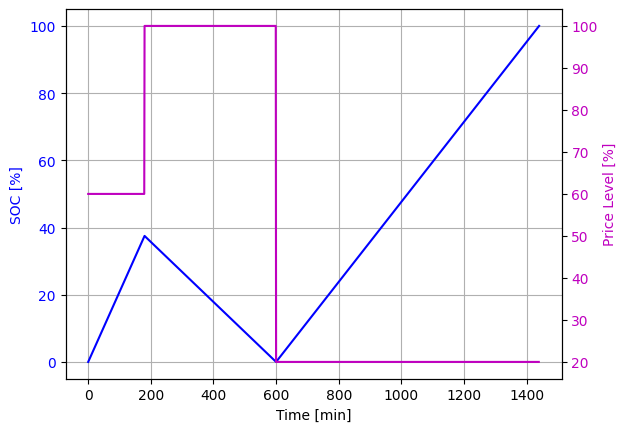

In [6]:
import matplotlib.pyplot as plt

p.value = np.concatenate((3*np.ones(3*60),
                          5*np.ones(7*60),
                          1*np.ones(14*60)), axis=0)
eta = 0.1
s.value = eta*p.value
Q.value = 1
C.value = 3*Q.value/(24*60)
D.value = 2*C.value
gamma.value = 100

val = problem.solve()

fig, ax1 = plt.subplots()

ax1.plot(100*q.value, color='b')
ax1.grid()
ax1.set_xlabel('Time [min]')
ax1.set_ylabel('SOC [%]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(100*p.value / max(p.value), color='m')
ax2.set_ylabel('Price Level [%]', color='m')
ax2.tick_params(axis='y', labelcolor='m')

We observe that it is optimal to charge the storage with maximum power during the medium price phase, then empty the storage when prices are highest, and then fully charge the storage for the lowest price of the day. Generating C source for the problem is as easy as:

In [7]:
from cvxpygen import cpg

cpg.generate_code(problem, code_dir='charging_code', solver='ECOS')

Generating code with CVXPYgen ...
CVXPYgen finished generating code.
Compiling python wrapper with CVXPYgen ... 


/usr/lib/python3/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
/workspaces/CVXPY_Hopper/jupyter/examples/charging/charging_code/c/solver_code/ecos_bb/ecos_bb.c: In function ‘set_prob’:
/workspaces/CVXPY_Hopper/jupyter/examples/charging/charging_code/c/solver_code/ecos_bb/ecos_bb.c:302:9: warning: case label value is less than minimum value for type [-Wswitch-outside-range]
  302 |         case MI_STAR:
      |         ^~~~


CVXPYgen finished compiling python wrapper.
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.4s)
-- Generating done (0.1s)
-- Build files have been written to: /workspaces/CVXPY_Hopper/jupyter/examples/charging/charging_code/c/build
[  3%] Building C object CMakeFiles/cpg.dir/src/cpg_workspace.c.o
[  6%] Building C object CMakeFiles/cpg.dir/src/cpg_solve.c.o
[ 10%] Building C object CMakeFiles/cpg.dir/solver_code/ecos_bb/ecos_bb.c.o
[ 13%] Building C object CMakeFiles/cpg.dir/solver_code/ecos_bb/ecos_bb_preproc.c.o


Now, you can use a python wrapper around the generated code as a custom CVXPY solve method.

In [8]:
from charging_code.cpg_solver import cpg_solve
import numpy as np
import pickle
import time

# load the serialized problem formulation
with open('charging_code/problem.pickle', 'rb') as f:
    prob = pickle.load(f)

# assign parameter values
prob.param_dict['p'].value = np.concatenate((3*np.ones(3*60),
                                             5*np.ones(7*60),
                                             1*np.ones(14*60)), axis=0)
eta = 0.1
prob.param_dict['s'].value = eta*prob.param_dict['p'].value
prob.param_dict['Q'].value = 1
prob.param_dict['C'].value = 5*prob.param_dict['Q'].value/(24*60)
prob.param_dict['D'].value = 2*prob.param_dict['C'].value

# solve problem conventionally
t0 = time.time()
# CVXPY chooses eps_abs=eps_rel=1e-5, max_iter=10000, polish=True by default,
# however, we choose the OSQP default values here, as they are used for code generation as well
val = prob.solve(solver='OSQP', eps_abs=1e-3, eps_rel=1e-3, max_iter=4000, polish=False)
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)

# solve problem with C code via python wrapper
prob.register_solve('CPG', cpg_solve)
t0 = time.time()
val = prob.solve(method='CPG')
t1 = time.time()
print('\nCVXPYgen\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)


CVXPY
Solve time: 249.508 ms
Objective function value: 0.779602


CVXPYgen
Solve time: 261.366 ms
Objective function value: 0.779060

------------------------------------------------------------------
	       SCS v3.2.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 4321, constraints m: 10084
cones: 	  z: primal zero / dual free vars: 1442
	  l: linear vars: 8642
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 0, acceleration_interval: 0
lin-sys:  sparse-direct
	  nnz(A): 15844, nnz(P): 1440
WARN: aa_init returned NULL, no acceleration applied.
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------

\[1\] Wang, Yang, Brendan O'Donoghue, and Stephen Boyd. "Approximate dynamic programming via iterated Bellman inequalities." International Journal of Robust and Nonlinear Control 25.10 (2015): 1472-1496.